In [1]:
import sys 
sys.path.insert(0,'/home/mohit/Downloads/code_notebooks/deep_boltzmann')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, create_RealNVPNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [7]:
model = ParticleDimer()

In [8]:
noise_intensity = 0.0
X0 = np.vstack([traj_closed_train, traj_open_train])
Nnoise = xval.shape[0]
X0noise = X0[np.random.choice(X0.shape[0], Nnoise)] + noise_intensity * np.random.randn(Nnoise, X0.shape[1])
X0noise = X0noise.astype(np.float32)

In [9]:
print(X0)
print(Nnoise)
print(X0noise)

[[-0.25        0.          0.25       ...  1.8         3.
   3.        ]
 [-0.25        0.          0.25       ...  1.8         3.
   3.        ]
 [-0.25        0.          0.25       ...  1.8         3.
   3.        ]
 ...
 [-1.0630857  -0.05359605  1.0554433  ...  1.7124369   3.0444221
   2.9039712 ]
 [-1.0630857  -0.05359605  1.0554433  ...  1.7124369   3.0444221
   2.9039712 ]
 [-1.0630857  -0.05359605  1.0554433  ...  1.7124369   3.0444221
   2.9039712 ]]
200002
[[-0.23959886 -0.16232413  0.5785     ...  1.8851823   2.879832
   3.0997849 ]
 [-1.0670818   0.20882595  1.0301403  ...  1.6908746   3.0170338
   3.0683339 ]
 [-0.4863673   0.03115962  0.41958237 ...  1.7766956   3.040611
   2.8758864 ]
 ...
 [-0.9120469   0.03349584  1.115191   ...  1.7815981   3.0811288
   3.0838714 ]
 [-1.0577117   0.14050864  0.9760318  ...  1.6225978   2.8635876
   2.8763301 ]
 [-1.0055455  -0.19437169  0.98083496 ...  1.8563112   2.8891647
   2.8942466 ]]


In [10]:
def load(filename, energy_model, clear_session=True):
        """ Loads parameters into model. Careful: this clears the whole TF session!!
        """
        from deep_boltzmann.util import load_obj
        if clear_session:
                keras.backend.clear_session()
        D = load_obj(filename)
        prior = D['prior']
        layerdicts = D['layers']
        layers = [eval(d['type']).from_dict(d) for d in layerdicts]
        return EnergyInvNet(energy_model, layers, prior=prior)

In [11]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh', whiten=X0)
bg = bg.load('ParticleModel.pkl',model)

W<RRRRRRRR>
W 76 0 0
< 76 0 0
R 38 38 0

R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0






In [12]:
print(bg.transform_xz(np.array(traj_closed_train[100])))

[[ 1.9409841   0.54439527  1.165148   -0.12898323  0.79317003 -0.08239648
   2.1080413   0.33137006 -0.81317365 -0.17675573  2.4454422   0.3767141
  -0.5203079   0.06310606  0.518147   -0.17674065 -1.1119643  -1.304368
   0.99522847  1.3684807  -0.5673883  -0.971212   -0.6355903   0.7788666
  -0.28659734 -0.19594899  0.8738725  -1.2306929   0.6144567   0.39634702
  -1.4109138   1.3781857   0.31148502 -0.3698604  -1.7629716   0.52627504
  -1.3798985  -0.58656746 -1.3586203   0.49767756  1.6338053  -0.00848758
   0.6361065  -0.21333903  1.8549298   0.3568051   1.1154948   0.08503734
  -0.23305506  0.8989614  -1.1179571   0.47706372  2.4120874   0.19267845
  -1.2725112  -0.13692385 -0.18470943 -0.41120458  0.10976018  0.5141052
  -0.78846925  0.70454216 -1.3085353  -0.3479609   0.26247227  0.4225598
   1.2961719   2.1185439   0.97781897 -1.7956232  -1.4863871  -1.8958106
   1.5784136  -0.7409886  -1.337869   -0.438689  ]]


In [13]:
def latent_interpolation(bg, x1, x2, nstep=1000, through_origin=False):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    if through_origin:
        zpath1 = z1 * (1-lambdas[::2])
        zpath2 = z2 * (lambdas[::2]) 
        zpath = np.vstack([zpath1, zpath2])
    else:
        zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [14]:
Emin = 1e9
bestpath = None
for i in range(90):
    for j in range(90):
        path = latent_interpolation(bg, traj_closed_train[i*100], traj_open_train[j*100], nstep=9)
        E = model.energy(path).max()
        if E < Emin:
            Emin = E
            bestpath = path

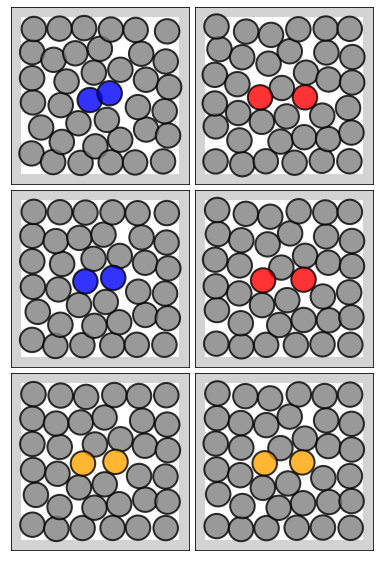

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6.5, 10))
model.draw_config(bestpath[0], axis=axes[0, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[2], axis=axes[1, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[3], axis=axes[2, 0], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[4], axis=axes[2, 1], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[5], axis=axes[1, 1], dimercolor='red', alpha=0.8);
model.draw_config(bestpath[7], axis=axes[0, 1], dimercolor='red', alpha=0.8);
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.savefig('interpolate.pdf', bbox_inches='tight')